<a href="https://colab.research.google.com/github/Sergei-N-Fedorov/Data_Analysis/blob/main/EMLM_Exercise1_Water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Student name: **Sergei Fedorov** <br>
Student number: **2511405** <br>
February, 3$^{\mathrm{rd}}$, 2026  <br>

# Exercise 1 | TKO_7092 Evaluation of Machine Learning Methods 2026

### Case study: Metal ion concentration prediction (video lectures, slides and scripts in MOOC2)

#### Prediction of the metal ion content from multi-parameter data

<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b>

    - Please use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html

    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).

    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).

    - Return your solution as a Jupyter Notebook (.ipynb) and as a PDF file generated from it. Please, add your full name to the file name.

    - Make sure that the code is runnable as is.

    - If AI was used, please explain at the end of the notebook, in the "AI usage disclaimer" section, how and in which parts it was applied.

    - The exercise will be graded as pass/fail.
    
    - Submit to moodle your solution on ** Wednesday 4 of February ** at the latest.
  
<b>Please be aware that you are required to submit your individual solution.<br>
Submissions with identical or similar code will result in a failure for the exercise.</b>

## Import libraries

In [1]:
# Importing libraries we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import somersd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut, cross_val_score
from sklearn.neighbors import KNeighborsRegressor

## Read and visualize the dataset

<p> <b>Note:</b> This dataset differs slightly from the one used in the video lectures. <br>
<b>In this dataset, some mixtures have 3 replicas, while others have 4 replicas. </b> </p>

In the following cell:
- Read the file water_data.csv
- Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 5 rows.
- Identify the inputs and the outputs columns.
- Provide the number of mixtures with 3 replicas and 4 replicas, respectively.

In [2]:
data = pd.read_csv('water_data.csv')

print("The dimensions of the data (rows, columns):", data.shape)
print("\n")
display(data.head(5))

The dimensions of the data (rows, columns): (243, 6)




,Mod1,Mod2,Mod3,c_total,Cd,Pb
0,-0.994673,-0.662192,0.327797,14.0,2.8,11.2
1,-0.982196,-0.662465,0.976950,14.0,0.0,14.0
2,2.063228,2.552820,1.681019,200.0,200.0,0.0
3,-0.839376,-0.586206,-1.471322,5000.0,3000.0,2000.0
4,-0.846858,-0.543135,-1.404644,5000.0,4000.0,1000.0


In [3]:
# Descriptive statistics for the dataset
data.describe()

,Mod1,Mod2,Mod3,c_total,Cd,Pb
count,2.430000e+02,2.430000e+02,2.430000e+02,243.000000,243.000000,243.000000
mean,2.558539e-17,1.462022e-17,3.106797e-17,802.275720,410.094650,392.181070
std,1.002064e+00,1.002064e+00,1.002064e+00,1423.090614,935.729511,871.750549
min,-1.001489e+00,-6.648221e-01,-1.471322e+00,0.000000,0.000000,0.000000
25%,-8.487104e-01,-6.427878e-01,-1.121154e+00,35.000000,8.400000,8.400000
50%,-4.738664e-01,-4.347768e-01,2.442237e-01,100.000000,40.000000,40.000000
75%,7.438977e-01,3.143626e-03,8.210014e-01,1000.000000,300.000000,300.000000
max,2.118800e+00,3.176672e+00,2.099097e+00,5000.000000,5000.000000,5000.000000


The ranges of the measured values differ, so we will need to standardize the data before applying KNN because it uses Euclidean distances.

In [4]:
# The input data (features)
inputs = ['Mod1', 'Mod2', 'Mod3']

# The output data (target)
outputs = ['c_total', 'Cd', 'Pb']

In [5]:
# Combining replicated mixtures into groups
grouped = data.groupby(outputs)

# Counting the number of objects in the groups
group_sizes = grouped.count()

group_sizes.head()

Mod1  Mod2  Mod3
c_total Cd  Pb                    
0.0     0.0 0.0      3     3     3
14.0    0.0 14.0     4     4     4
        2.8 11.2     4     4     4
        5.6 8.4      3     3     3
        8.4 5.6      3     3     3

In [6]:
# Counting different values of group sizes
display(group_sizes['Mod1'].value_counts())

,count
Mod1,
4,42
3,25


The dataset has 243 rows and 6 columns.

3 columns `Mod1`, `Mod2`, `Mod3` contain results of measurements (i.e., inputs for the model). 3 other columns are the real metal concentration values,that the model should learn to predict (i.e., outputs).

The rows are represented by groups of 3 or 4 replicas:
there are

* 25 groups of 3 measurements,

* 42 groups of 4 measurements,

each for one specific mixture. In total, there are $25 + 42 = 67$ different mixtures.

## C-index code

In [7]:
# In this cell, there is the fuction that computes the c-index value based on Somers' D statistic
# as the evaluation metric in LOOCV and LROCV methods.

def cindex(true, pred):
    s_d = somersd(true, y=pred, alternative='two-sided')
    c_index = (s_d.statistic + 1.0)/2.0
    return c_index

In [8]:
# Defining the values for parameter K of KNN regressors

k_values = [1, 3, 5, 7]

## Leave-One-Out cross-validation

In [9]:
# Leave-One-Out cross-validation and the corresponding results

loo = LeaveOneOut()
loo_pred = np.zeros((len(data), len(outputs), len(k_values)))
       # 3-dim. array of predictions (LOOCV split = datapoint, output, K)

for train_index, test_index in loo.split(data):   # make a split (LOO)
  X_train, X_test = data[inputs].iloc[train_index], data[inputs].iloc[test_index]
  y_train, y_test = data[outputs].iloc[train_index], data[outputs].iloc[test_index]

  scaler = StandardScaler()     # standardize the input
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  for i in range(len(outputs)): # for each of 3 output features
    for k in range(len(k_values)):          # loop over K
      model = KNeighborsRegressor(n_neighbors = k_values[k], metric = "euclidean")
      model.fit(X_train, y_train[outputs[i]])   # train the model
      loo_pred[test_index, i, k] = model.predict(X_test)  # predict for the point left out

loo_scores = np.zeros((len(outputs), len(k_values)))  # C-index for each (output, K)
for i in range(len(outputs)):
  for k in range(len(k_values)):
    loo_scores[i, k] = cindex(data[outputs[i]], loo_pred[:, i, k])

Here are the C-indices for 3 outputs (rows) and 4 values of K (columns) in the case of **Leave-One-Out** CV:

In [10]:
loo_scores

array([[0.91218351, 0.91078931, 0.89115887, 0.87870394],
       [0.918931  , 0.90300322, 0.85584555, 0.82425813],
       [0.88365498, 0.8771983 , 0.85163914, 0.82978989]])

## Leave-Replicas-Out cross-validation

In [11]:
# Creating the list of group labels (for groups of replicas)
group_labels = grouped.ngroup()

In [12]:
# Leave-Replicas-Out cross-validation

lro = LeaveOneGroupOut()
lro_pred = np.zeros((len(data), len(outputs), len(k_values)))
       # 3-dim. array of predictions (datapoint, output, K)

for train_index, test_index in lro.split(data, groups = group_labels):   # make a split (LGO)
  X_train, X_test = data[inputs].iloc[train_index], data[inputs].iloc[test_index]
  y_train, y_test = data[outputs].iloc[train_index], data[outputs].iloc[test_index]

  scaler = StandardScaler()     # standardize the input
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  for i in range(len(outputs)): # for each of 3 output features
    for k in range(len(k_values)):          # loop over K
      model = KNeighborsRegressor(n_neighbors = k_values[k], metric = "euclidean")
      model.fit(X_train, y_train[outputs[i]])   # train the model
      lro_pred[test_index, i, k] = model.predict(X_test)  # predict for the group left out

lro_scores = np.zeros((len(outputs), len(k_values)))  # C-index for each (output, K)
for i in range(len(outputs)):
  for k in range(len(k_values)):
    lro_scores[i, k] = cindex(data[outputs[i]], lro_pred[:, i, k])

Here are the C-indices for 3 outputs (rows) and 4 values of K (columns) in the case of **Leave-Replicas-Out** CV:

In [13]:
lro_scores

array([[0.8217831 , 0.81005317, 0.81414284, 0.81576012],
       [0.75504112, 0.75915266, 0.74193779, 0.7410261 ],
       [0.75461064, 0.75726822, 0.74735134, 0.74792209]])

## Compare Leave-One-Out and Leave-Replicas-Out Results

Plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

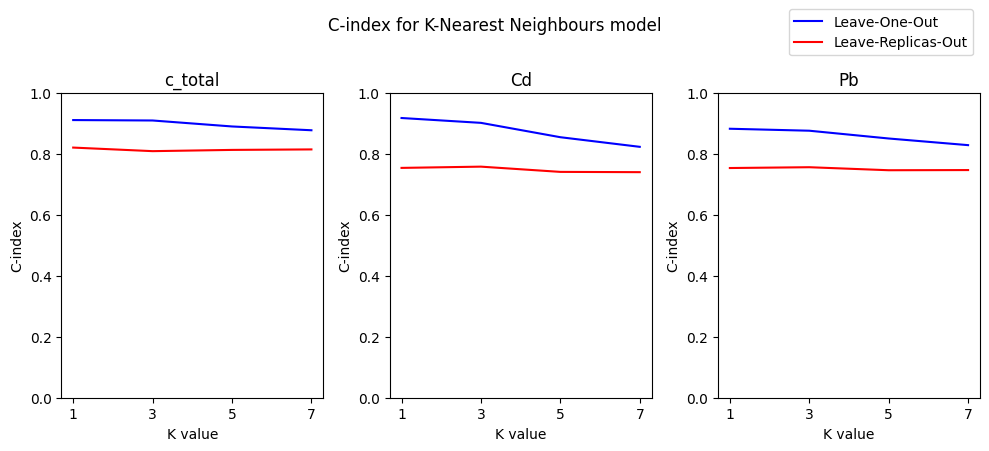

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i in range(len(outputs)):
  axes[i].plot(k_values, loo_scores[i], color = "blue", label = 'Leave-One-Out')
  axes[i].plot(k_values, lro_scores[i], color = "red", label = 'Leave-Replicas-Out')
  axes[i].set_ylim(0.0, 1.0)
  axes[i].set_xticks(k_values)
  # axes[i].set_xticklabels(["1", "3", "5", "7"])

  axes[i].set_xlabel("K value")
  axes[i].set_ylabel("C-index")
  axes[i].set_title(outputs[i])

plt.tight_layout()

plt.suptitle("C-index for K-Nearest Neighbours model", y = 1.1)

plt.legend(bbox_to_anchor = (1, 1.2), loc = 'center right')

plt.show()

## Interpretation of results
#### Answer the following questions based on the results obtained
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers:

1.   Leave-One-Out (LOOCV) produces more optimistic results in the sense that the scores are higher than could be.
This is apparently because for each CV split the test datapoint has its replicas in the training set. So, the model is exposed to similar datapoint during the training which makes its task for the test datapoint is easier.

2.   Leave-Replicas-Out (LROCV via LOGOCV) provides a better (i.e., more accurate) estimation. This is because the test set consists of all the replicas of one concentration at a time, hence the training set doesn't contain data similar to the test datapoints. So, the model cannot much benefit from the training set specifically for predictions on the test set in each CV split. One could say that the model's work is more fair in this case.



## AI usage disclaimer

In [15]:
# In case AI was used to solve the exercise, please explain how and in which parts it was used.

AI was used for

* clarifying causes of errors in the code,

* specifying syntax of some functions and methods,

* better understanding some theoretical aspects (CV, one multi-output model vs. multiple one-output models, Somers' D statistics),
